In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

In [19]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
data_df = pd.read_csv('Data/Raw_data_sales_full_excl_nbrs_incl_police_schools.csv')
data_df.dropna(inplace=True)
data_df["is_apartment"] = data_df["is_apartment"].astype(int)
data_df["from_10_to_20_years"] = data_df["from_10_to_20_years"].astype(int)
data_df["from_5_to_10_years"] = data_df["from_5_to_10_years"].astype(int)
data_df["More_than_20_years"] = data_df["More_than_20_years"].astype(int)
data_df["is_new"] = data_df["is_new"].astype(int)

In [13]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(data_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

66667 examples in training, 16637 examples in testing.


In [14]:
label = 'price_m2'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [15]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [16]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpkm3e2ysv as temporary training directory


In [17]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mae", "acc", "rmse"])
rf.fit(x=train_ds)

Use /tmp/tmpqxmznby7 as temporary training directory
Reading training dataset...


2023-04-29 22:29:38.535001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype double and shape [66667]
	 [[{{node Placeholder/_12}}]]


Training dataset read in 0:00:01.320083. Found 66667 examples.
Training model...


[INFO 23-04-29 22:30:20.3852 UTC kernel.cc:1242] Loading model from path /tmp/tmpqxmznby7/model/ with prefix 49897138c1274fd1
[INFO 23-04-29 22:30:25.7443 UTC decision_forest.cc:660] Model loaded with 300 root(s), 2588274 node(s), and 19 input feature(s).
[INFO 23-04-29 22:30:25.7444 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-04-29 22:30:25.7444 UTC kernel.cc:1074] Use fast generic engine


Model trained in 0:00:46.759993
Compiling model...


2023-04-29 22:30:26.622569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype double and shape [66667]
	 [[{{node Placeholder/_5}}]]


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


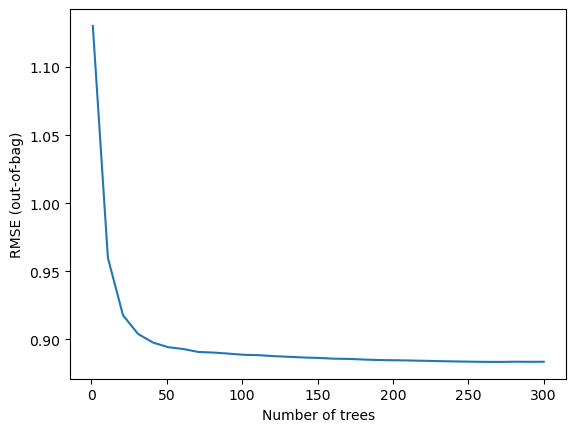

In [20]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()